In [32]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
from sklearn.utils import shuffle

import pandas as pd
import numpy as np
import os
import glob 
import pickle
from math import *
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


In [33]:
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "acc_x_",
    "acc_y_",
    "acc_z_",
    "total_acc"
]

# Output classes to learn how to classify
LABELS = [
    "MOTOR_BIKE", 
    "CAR",
    "WALKING",
    "CYCLING"
]

In [34]:
def GaussianFilter(df, window_length):
    df1 = df
    
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

#     df1['GX'] = gaussian_filter(df['GX'], window_length)
#     df1['GY'] = gaussian_filter(df['GY'], window_length)
#     df1['GZ'] = gaussian_filter(df['GZ'], window_length)

    return df1

In [35]:
def Amplitude(df, input_features, out_feature):
    df[out_feature] = (df[input_features[0]]**2 + df[input_features[1]]**2  + df[input_features[2]]**2)**(1/2)

In [36]:
def segmentation(df, N_TIME_STEPS):
    
    N_FEATURES = 1
    step = 50
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
#         gx = df['GX'].values[i: i + N_TIME_STEPS]
#         gy = df['GY'].values[i: i + N_TIME_STEPS]
#         gz = df['GZ'].values[i: i + N_TIME_STEPS]
#         mean_gx = gx.mean()
#         mn_gx = [mean_gx]*N_TIME_STEPS
#         mean_gy = gy.mean()
#         mn_gy = [mean_gy]*N_TIME_STEPS
#         mean_gz = gz.mean()
#         mn_gz = [mean_gz]*N_TIME_STEPS
        
        ax = df['AX'].values[i: i + N_TIME_STEPS]
        ay = df['AY'].values[i: i + N_TIME_STEPS]
        az = df['AZ'].values[i: i + N_TIME_STEPS]
        
        mean_ax = ax.mean()
        mn_ax = ax-mean_ax
        mean_ay = ay.mean()
        mn_ay = ay-mean_ay
        mean_az = az.mean()
        mn_az = az-mean_az
        
        ma = df['mAcc'].values[i: i + N_TIME_STEPS]
#         mz = df['mGyro'].values[i: i + N_TIME_STEPS]
        
        mean_a = ma.mean()
        mn_a = ax-mean_a
        
        label = "ST"
        segments.append([ax, ay, az, ma, mn_ax, mn_ay, mn_az, mn_a])
#         labels = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        labels.append(label)
    return segments, labels

In [37]:
def data_preprocessing(df):
    #mean feature of 3-axis accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = 'mAcc'
    Amplitude(df, input_features, output_feature)
    
    #mean feature of 3-axis gyroscope data
#     input_features = ['GX', 'GY', 'GZ']
#     output_feature = 'mGyro'
#     Amplitude(df, input_features, output_feature)
    
    #apply gaussian filter with window size 10
    df = GaussianFilter(df, 10)
    return df

In [38]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
#     df['GX'] = df_gyro['X']
#     df['GY'] = df_gyro['Y']
#     df['GZ'] = df_gyro['Z']
    
    return df

In [39]:
def read_files(acc_file, gyro_file, activity):
    df = read_csv_file(acc_file, gyro_file, activity)
    df.reset_index(drop = True , inplace = True)
    if('Milliseconds' in df.columns):
        df = df.drop('Milliseconds', axis=1)
    if('Timestamp' in df.columns):
        df = df.drop('Timestamp', axis=1)
    df = data_preprocessing(df)
    df['activity'] = activity
    
    return df
    

In [40]:
#data loading


path_acc = os.getcwd() + '/data/Bike2308/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/Bike2308/*/*Gyroscope.csv'
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)

bike_df = []
bike_df = pd.Series(bike_df)
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    df_this = read_files(acc_file, gyro_file, 'bike')
    n = len(df_this)
    df_this = df_this[1500 : n-500]
    df_this.to_csv('my_csv.csv', mode='a', header=False)
    bike_df = pd.concat([bike_df, df_this])
bike_df.reset_index(drop = True, inplace = True)
print(bike_df.shape)
bike_df.head()


/home/vicky/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:77: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


(53698, 6)


,0,AX,AY,AZ,mAcc,activity
0,NaN,0.053224,0.314816,-0.039182,1.480741,bike
1,NaN,0.050394,0.317808,-0.024306,0.503951,bike
2,NaN,0.047070,0.319707,-0.010741,3.321339,bike
3,NaN,0.043323,0.320499,0.001363,2.796644,bike
4,NaN,0.039209,0.320110,0.011780,0.957629,bike


In [10]:
#data loading

path_acc = os.getcwd() + '/data/bike/*/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/bike/*/*/*Gyroscope.csv'
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)

for acc_file, gyro_file in zip(acc_files, gyro_files) :
    df_this = read_files(acc_file, gyro_file, 'bike')
    n = len(df_this)
    df_this = df_this[1500 : n-1500]
    bike_df = pd.concat([bike_df, df_this])
bike_df.reset_index(drop = True, inplace = True)
bike_df.dropna()
print(bike_df.shape)
bike_df.head()


(298078, 6)


,0,AX,AY,AZ,mAcc,activity
0,NaN,0.053224,0.314816,-0.039182,1.480741,bike
1,NaN,0.050394,0.317808,-0.024306,0.503951,bike
2,NaN,0.047070,0.319707,-0.010741,3.321339,bike
3,NaN,0.043323,0.320499,0.001363,2.796644,bike
4,NaN,0.039209,0.320110,0.011780,0.957629,bike


In [11]:
#data loading

path_acc = os.getcwd() + '/data/walk/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/walk/*/*Gyroscope.csv'
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)

walk_df = []
walk_df = pd.Series(walk_df)
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    df_this = read_files(acc_file, gyro_file, 'walk')
    n = len(df_this)
    df_this = df_this[1500 : n-500]
    walk_df = pd.concat([walk_df, df_this])
walk_df.reset_index(drop = True, inplace = True)
print(walk_df.shape)
walk_df.head()


/home/vicky/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:77: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


(92764, 6)


,0,AX,AY,AZ,mAcc,activity
0,NaN,0.060464,-5.881064,0.776747,8.245067,walk
1,NaN,-0.131828,-6.059065,0.801559,8.420892,walk
2,NaN,-0.294295,-6.201744,0.813941,8.620252,walk
3,NaN,-0.423835,-6.307902,0.813265,8.859215,walk
4,NaN,-0.517898,-6.376554,0.799069,9.162117,walk


In [12]:
path_acc = os.getcwd() + '/data/Car1109out/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/Car1109out/*/*Gyroscope.csv' 
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
car_df= read_files(acc_files[0], gyro_files[0], 'car')
n = len(car_df)
car_df = car_df[350:n-500]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    df_this = read_files(acc_file, gyro_file, 'car')
    n = len(df_this)
    df_this = df_this[350 : n-500]
    car_df = pd.concat([car_df, df_this])
car_df.reset_index(drop = True, inplace = True)
car_df.dropna()
print(car_df.shape)
car_df.head()

(108368, 5)


,AX,AY,AZ,mAcc,activity
0,0.151147,-0.548212,0.384174,5.896712,car
1,0.145558,-0.549001,0.315767,6.891665,car
2,0.131640,-0.550599,0.237944,5.505644,car
3,0.109519,-0.552682,0.153242,4.220319,car
4,0.079650,-0.554942,0.064491,4.958700,car


In [13]:
path_acc = os.getcwd() + '/data/Car28march/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/Car28march/*/*Gyroscope.csv' 
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
# car_df= read_files(acc_files[0], gyro_files[0], 'car')
# n = len(car_df)
# car_df = car_df[350:n-500]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    df_this = read_files(acc_file, gyro_file, 'car')
    n = len(df_this)
    df_this = df_this[350 : n-500]
    car_df = pd.concat([car_df, df_this])
car_df.reset_index(drop = True, inplace = True)
print(car_df.shape)
car_df.head()

(261908, 5)


,AX,AY,AZ,mAcc,activity
0,0.151147,-0.548212,0.384174,5.896712,car
1,0.145558,-0.549001,0.315767,6.891665,car
2,0.131640,-0.550599,0.237944,5.505644,car
3,0.109519,-0.552682,0.153242,4.220319,car
4,0.079650,-0.554942,0.064491,4.958700,car


In [14]:
path_acc = os.getcwd() + '/data/Cycling/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/Cycling/*/*Gyroscope.csv' 
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
cycle_df= read_files(acc_files[0], gyro_files[0], 'cycle')
n = len(cycle_df)
cycle_df = cycle_df[1350:n-1500]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    df_this = read_files(acc_file, gyro_file, 'car')
    n = len(df_this)
    df_this = df_this[1350 : n-1500]
    cycle_df = pd.concat([cycle_df, df_this])
cycle_df.reset_index(drop = True, inplace = True)
cycle_df.dropna()
print(cycle_df.shape)
cycle_df.head()

(116128, 5)


,AX,AY,AZ,mAcc,activity
0,0.359546,-0.533481,0.912715,2.181390,cycle
1,0.329619,-0.505372,0.967403,1.066422,cycle
2,0.300126,-0.476127,1.017169,4.193872,cycle
3,0.271456,-0.446223,1.061183,2.663096,cycle
4,0.243963,-0.415988,1.098812,1.326814,cycle


In [15]:
segment_size = 200

In [16]:
#data segmentation
walk_segments, walk_labels = segmentation(walk_df, segment_size)
walk_segments = np.transpose(walk_segments, (0, 2, 1))
np.array(walk_segments).shape

(1852, 200, 8)

In [17]:
walk_segments[0][0]

array([ 0.06046419, -5.8810642 ,  0.77674709,  8.24506722, -1.81956451,
       -2.93379932,  0.24094127, -7.93881995])

In [18]:
#data segmentation
bike_segments, bike_labels = segmentation(bike_df, segment_size)
bike_segments = np.transpose(bike_segments, (0, 2, 1))
np.array(bike_segments).shape

(5958, 200, 8)

In [19]:
#data segmentation
car_segments, car_labels = segmentation(car_df, segment_size)
car_segments = np.transpose(car_segments, (0, 2, 1))
np.array(car_segments).shape

(5235, 200, 8)

In [20]:
#data segmentation
cycle_segments, cycle_labels = segmentation(cycle_df, segment_size)
cycle_segments = np.transpose(cycle_segments, (0, 2, 1))
np.array(cycle_segments).shape

(2319, 200, 8)

In [21]:
train = np.concatenate((bike_segments, car_segments, walk_segments, cycle_segments), axis=0)

In [22]:
np.array(train).shape

(15364, 200, 8)

In [23]:
label1 = [0]*len(bike_segments)
label2 = [1]*len(car_segments)
label3 = [2]*len(walk_segments)
label4 = [3]*len(cycle_segments)
label = label1 + label2 + label3 + label4
np.array(label).shape
label = np.array(label).reshape(len(label), 1) 
label.shape

(15364, 1)

In [24]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=RANDOM_SEED)

In [25]:
# X_train = shuffle(X_train)

In [26]:
np.array(X_train).shape


(12291, 200, 8)

In [27]:
# Input Data 

training_data_count = len(X_train)  # training series (with 50% overlap between each serie)
test_data_count = len(X_test)  #  testing series
n_steps = len(X_train[0])  # 400 timesteps per series
n_input = len(X_train[0][0])  # 8 input pa.90618rameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 4 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.002
lambda_loss_amount = 0.0015
training_iters = training_data_count * 100  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training

tf.reset_default_graph()
# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(np.array(X_test).shape, np.array(y_test).shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(3073, 200, 8) (3073, 1) -0.0324194405444 1.72774357083
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [28]:
def LSTM_RNN(_X, _weights, _biases):
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # ReLU activation, thanks to Yu Zhao for adding this improvement here:
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
#     tf.reset_default_graph()
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

def extract_batch_size(_train, step, batch_size): 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_, n_classes=n_classes):
    
    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [29]:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [30]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))

Training iter #1500:   Batch Loss = 2.492467, Accuracy = 0.34066668152809143
PERFORMANCE ON TEST SET: Batch Loss = 1.8454489707946777, Accuracy = 0.37617963552474976
Training iter #30000:   Batch Loss = 1.151133, Accuracy = 0.7206666469573975
PERFORMANCE ON TEST SET: Batch Loss = 1.1278462409973145, Accuracy = 0.7302310466766357
Training iter #60000:   Batch Loss = 0.971432, Accuracy = 0.7960000038146973
PERFORMANCE ON TEST SET: Batch Loss = 0.9525691270828247, Accuracy = 0.8099576830863953
Training iter #90000:   Batch Loss = 0.889680, Accuracy = 0.8360000252723694
PERFORMANCE ON TEST SET: Batch Loss = 0.870324969291687, Accuracy = 0.8359909057617188
Training iter #120000:   Batch Loss = 0.850504, Accuracy = 0.8420000076293945
PERFORMANCE ON TEST SET: Batch Loss = 0.8122645020484924, Accuracy = 0.8551903963088989
Training iter #150000:   Batch Loss = 0.796910, Accuracy = 0.8613333106040955
PERFORMANCE ON TEST SET: Batch Loss = 0.7776918411254883, Accuracy = 0.8704848885536194
Training

/home/vicky/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


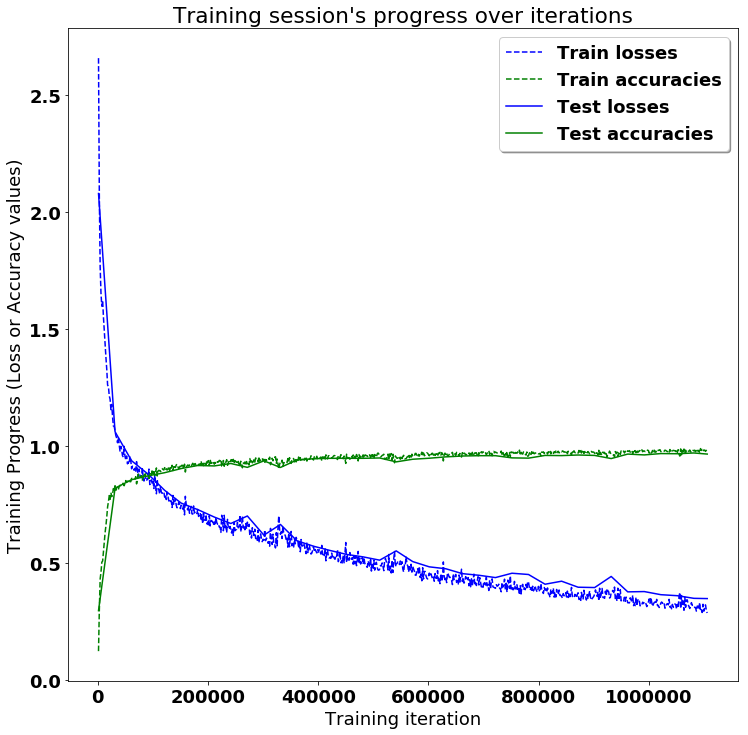

In [116]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

Testing Accuracy: 94.89098787307739%

Precision: 94.9121426972565%
Recall: 94.89098600715913%
f1_score: 94.8885247521252%

Confusion Matrix:
[[1106   80    0   12]
 [  50 1005    0    2]
 [   0    0  367    0]
 [  10    2    1  438]]

Confusion matrix (normalised to % of total test data):
[[  3.59908867e+01   2.60331917e+00   0.00000000e+00   3.90497863e-01]
 [  1.62707460e+00   3.27041969e+01   0.00000000e+00   6.50829822e-02]
 [  0.00000000e+00   0.00000000e+00   1.19427271e+01   0.00000000e+00]
 [  3.25414896e-01   6.50829822e-02   3.25414911e-02   1.42531719e+01]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


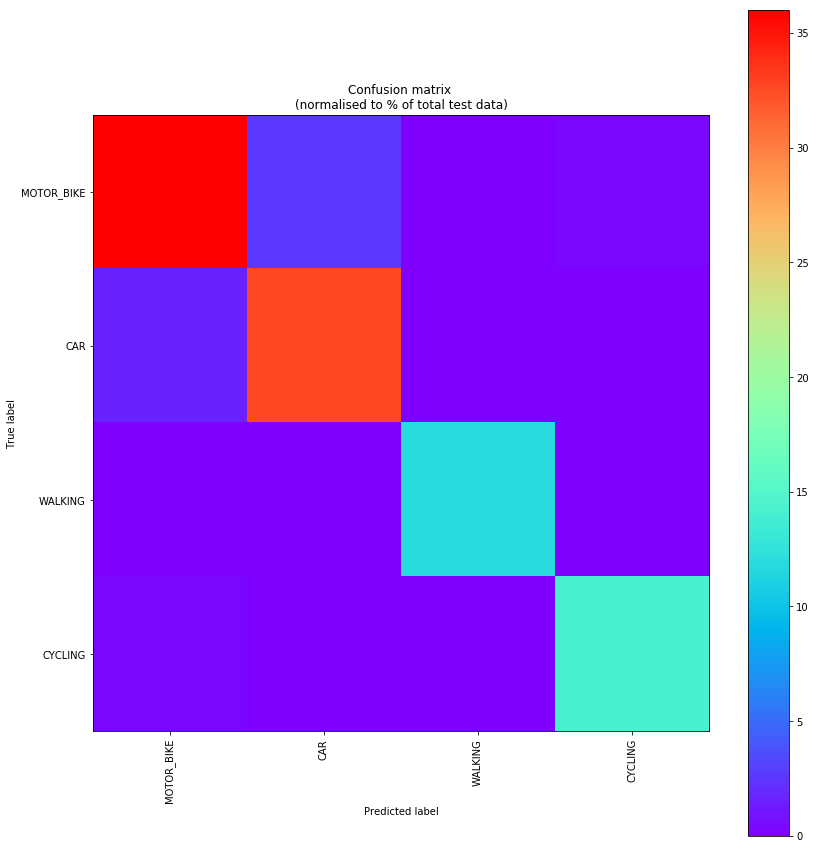

In [31]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()